Let's import useful packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-whitegrid')

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

Load the data.

In [5]:
df = pd.read_csv(filepath_or_buffer='task_d.csv')
display(df.head())

,x,y,z,x*x,2*y,2*z+3*x*x,w,target
0,-0.581066,0.841837,-1.012978,-0.604025,0.841837,-0.665927,-0.536277,0
1,-0.894309,-0.207835,-1.012978,-0.883052,-0.207835,-0.917054,-0.522364,0
2,-1.207552,0.212034,-1.082312,-1.150918,0.212034,-1.166507,0.205738,0
3,-1.364174,0.002099,-0.943643,-1.280666,0.002099,-1.266540,-0.665720,0
4,-0.737687,1.051772,-1.012978,-0.744934,1.051772,-0.792746,-0.735054,0


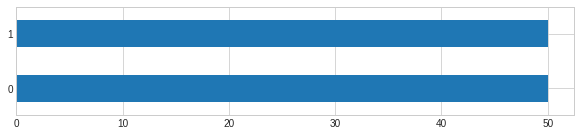

In [6]:
plt.figure(figsize=(10, 2))
df['target'].value_counts().plot(kind='barh')
plt.show()

This data is a balanced data and has two classes $0$ and $1$.

In [7]:
X = df.drop(labels=['target'], axis=1)
display(X.head())
y = df['target']
display(y.head())

,x,y,z,x*x,2*y,2*z+3*x*x,w
0,-0.581066,0.841837,-1.012978,-0.604025,0.841837,-0.665927,-0.536277
1,-0.894309,-0.207835,-1.012978,-0.883052,-0.207835,-0.917054,-0.522364
2,-1.207552,0.212034,-1.082312,-1.150918,0.212034,-1.166507,0.205738
3,-1.364174,0.002099,-0.943643,-1.280666,0.002099,-1.266540,-0.665720
4,-0.737687,1.051772,-1.012978,-0.744934,1.051772,-0.792746,-0.735054


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

---

Heat Map

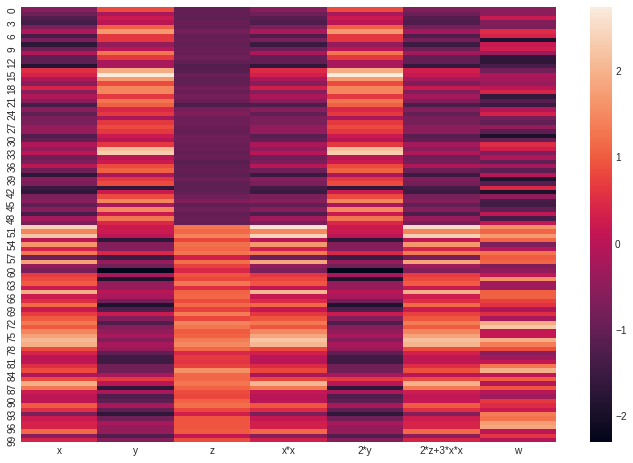

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=X)
plt.show()

Perturbation Test

In [9]:
class PerturbationTest(object):
    """
    This class performs Perturbation Test on the data.
    Perturbation Test is used to check whether the features are collinear or not.
    """
    
    def __init__(self, X, y, model):
        self.features = list(X.columns)
        self.X = self.standardization(X=X.values)
        self.nX = self.make_features_noisy()
        self.y = y
        self.all_models = ['lr', 'svc']
        self.model = 'lr' if model not in self.all_models else model
        self.loss = 'log_loss' if model == 'lr' else 'hinge'
        self.params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'loss': [self.loss]}
        self.best_alpha = self.compute_best_alpha()
    
    def standardization(self, X):
        """
        This method performs standardization on each column.
        """
        std = StandardScaler()
        X = std.fit_transform(X=X)
        return X
    
    def compute_best_alpha(self):
        """
        This method computes the best alpha using GridSearchCV.
        """
        a_clf = SGDClassifier()
        grid_model = GridSearchCV(estimator=a_clf,
                                  param_grid=self.params,
                                  n_jobs=-1,
                                  scoring='roc_auc')
        grid_model.fit(X=self.X, y=self.y)
        best_params = grid_model.best_params_['alpha']
        return best_params
    
    def make_features_noisy(self):
        """
        This method adds some noise 'e' to each feature vector.
        """
        noise = 10 ** (-2)
        nX = self.X + noise
        return nX
    
    def fit_model(self, noise_flag=False):
        """
        This method fits the model to the data.
        """
        clf = SGDClassifier(alpha=self.best_alpha, loss=self.loss)
        if noise_flag:
            clf.fit(X=self.nX, y=self.y)
            w = clf.coef_[0]
            c = clf.intercept_[0]
            a = clf.score(X=self.nX, y=self.y)
        else:
            clf.fit(X=self.X, y=self.y)
            w = clf.coef_[0]
            c = clf.intercept_[0]
            a = clf.score(X=self.X, y=self.y)
        return w, c, a
    
    def compute_weight_difference(self, w1, w2, n=4):
        """
        This method computes the weight difference.
        """
        w_ = np.abs(w1 - w2)
        fw = {f: w for (f, w) in zip(self.features, w_)}
        print("Weights difference:\n{}".format(fw))
        fw = dict(sorted(fw.items(), key=lambda x:x[1], reverse=True)[:n])
        return fw
    
    def compute_accuracy_difference(self, a1, a2):
        """
        This method computes the accuracy difference.
        """
        a_ = abs(a1 - a2)
        return a_
    
    def print_results(self):
        """
        This method prints the results.
        """
        mname = 'Logistic Regression' if (self.model == 'lr') else 'Support Vector Classifier'
        print("{}".format(mname))
        
        print("\n2.")
        print("Best alpha: {}\nLoss: {}".format(self.best_alpha, self.loss))
        
        print("\n3.")
        print("Best model")
        w1, b1, a1 = self.fit_model(noise_flag=False)
        print("Weights:\n{}".format(w1))
        print("Intercept: {}".format(b1))
        print("Accuracy: {}".format(a1))
        
        print("\n4.")
        print("Best model (noisy)")
        w2, b2, a2 = self.fit_model(noise_flag=True)
        print("Weights:\n{}".format(w2))
        print("Intercept: {}".format(b2))
        print("Accuracy: {}".format(a2))
        
        print("\n5.")
        da = self.compute_accuracy_difference(a1=a1, a2=a2)
        print("Accuracy difference: {}".format(da))
        tf = self.compute_weight_difference(w1=w1, w2=w2)
        print("Top 4 features (with highest % change):\n{}".format(tf))
        
        return None

In [10]:
pt = PerturbationTest(X=X, y=y, model='lr')
pt.print_results()

Logistic Regression

2.
Best alpha: 0.0001
Loss: log_loss

3.
Best model
Weights:
[ 2.14585287 -3.45897522  5.28020703  2.0226366  -3.45897522  2.45788252
  1.01263436]
Intercept: -1.480268236954756
Accuracy: 1.0

4.
Best model (noisy)
Weights:
[ 1.90178222 -4.28972311  7.90760272  1.96152382 -4.28972311  2.72051414
  2.66064561]
Intercept: -3.569633796682649
Accuracy: 1.0

5.
Accuracy difference: 0.0
Weights difference:
{'x': 0.24407064827911396, 'y': 0.830747892015407, 'z': 2.6273956881204006, 'x*x': 0.061112783947426585, '2*y': 0.830747892015407, '2*z+3*x*x': 0.26263162333665635, 'w': 1.6480112552202246}
Top 4 features (with highest % change):
{'z': 2.6273956881204006, 'w': 1.6480112552202246, 'y': 0.830747892015407, '2*y': 0.830747892015407}


In [11]:
pt = PerturbationTest(X=X, y=y, model='svc')
pt.print_results()

Support Vector Classifier

2.
Best alpha: 0.0001
Loss: hinge

3.
Best model
Weights:
[10.69971481 -8.15698609 20.57682688  9.79504231 -8.15698609 11.29991369
  3.40189249]
Intercept: 10.025744971708717
Accuracy: 1.0

4.
Best model (noisy)
Weights:
[10.46649298 -9.81386843 22.66297962  9.60105502 -9.81386843 11.37596829
 14.91496135]
Intercept: 10.096357088208572
Accuracy: 1.0

5.
Accuracy difference: 0.0
Weights difference:
{'x': 0.23322183208158265, 'y': 1.6568823402674067, 'z': 2.0861527438310254, 'x*x': 0.19398728533632337, '2*y': 1.6568823402674067, '2*z+3*x*x': 0.07605459363395717, 'w': 11.51306886632698}
Top 4 features (with highest % change):
{'w': 11.51306886632698, 'z': 2.0861527438310254, 'y': 1.6568823402674067, '2*y': 1.6568823402674067}


---

__Conclusion__:

1. From the weights difference, we can say that features are multi-collinear, because we see a drastic change in the weights after introducing a small noise.
2. No difference in accuracy is observed even after noise.
3. For both logistic regression and support vector classifier, best alpha turned out to be $0.0001$.
4. Dataset size is very small.

---

End of the file.